In [1]:
import pymatbridge as pymat
ip = get_ipython()
pymat.load_ipython_extension(ip)

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-89bf849a-298a-40a1-9162-c8310462c9ed
Send 'exit' command to kill the server
..............MATLAB started and connected!


/usr/local/lib/python3.4/dist-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Function evaluation     71;  Value 3.076030e+02
Function evaluation     74;  Value 3.395535e+02
Log-likelihood learned w/out Kronecker: 24633.2168
Log-likelihood learned with Kronecker: 518.3130
Log-likelihood with Kronecker + Fiedler bound: NaN
Function evaluation      0;  Value 2.584582e+03

ans =

    0.8123    1.4525    0.5638    1.4525

Function evaluation     69;  Value 3.190207e+02
Function evaluation     65;  Value 3.507339e+02
Log-likelihood learned w/out Kronecker: 16044.3448
Log-likelihood learned with Kronecker: 323.6704
Log-likelihood with Kronecker + Fiedler bound: NaN
Function evaluation      0;  Value 2.716434e+03

ans =

    0.9546    1.3100    0.6613    1.3100



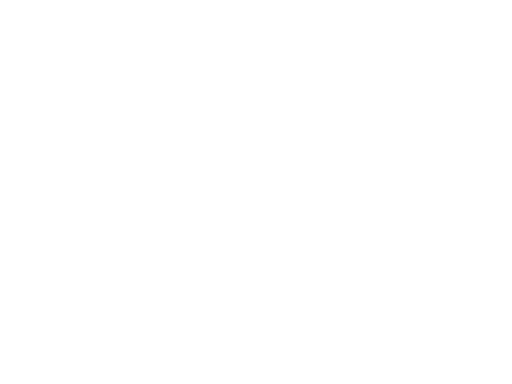

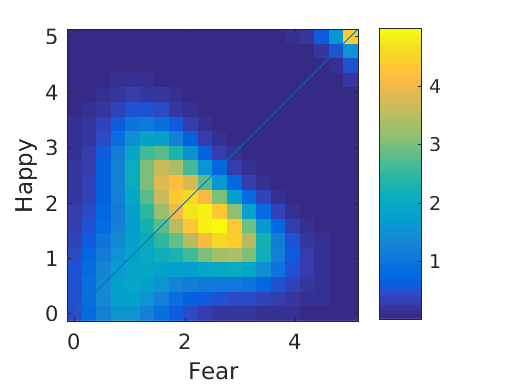

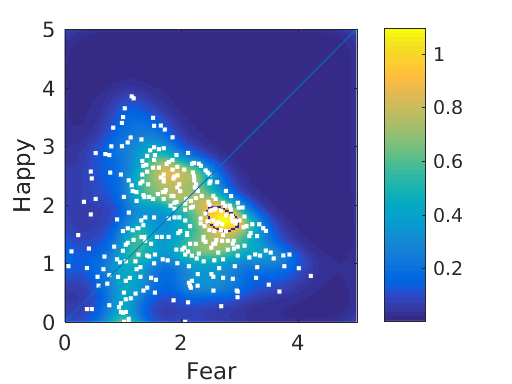

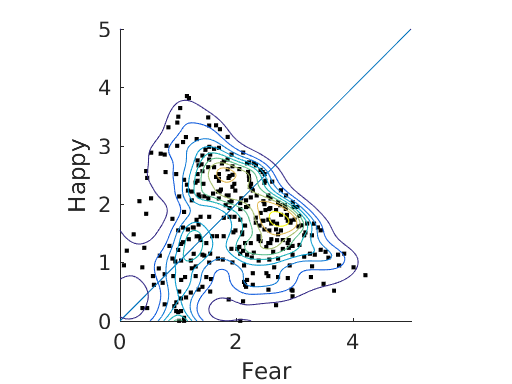

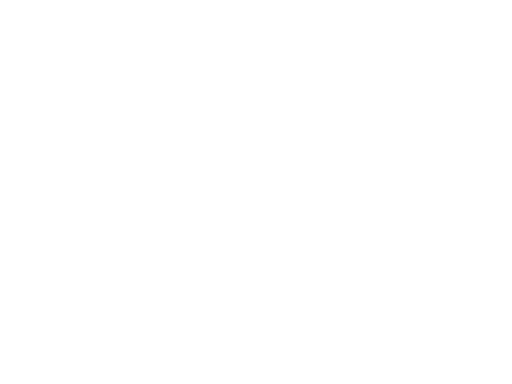

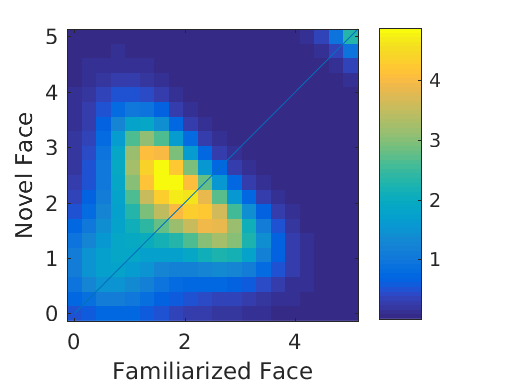

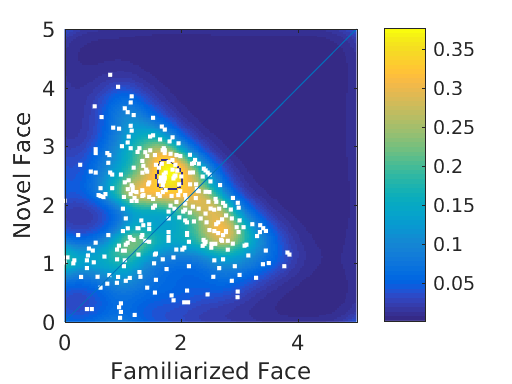

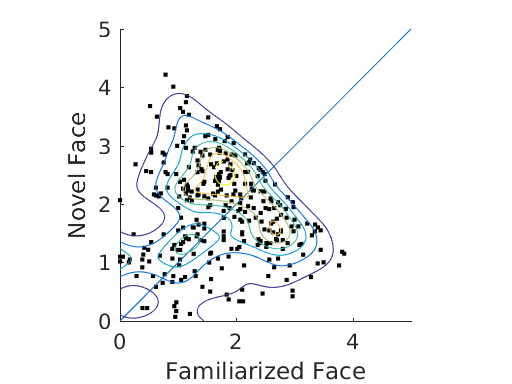

In [2]:
%%matlab -o meanmap1 -o meanmap2

% code adapted from http://www.cs.cmu.edu/~andrewgw/pattern/
% which is based on the paper
% Fast kronecker inference in Gaussian processes with non-Gaussian likelihoods
% Seth Flaxman, Andrew Gordon Wilson, Daniel Neill, Hannes Nickisch, and Alexander J. Smola
% To appear at the International Conference on Machine Learning (ICML), 2015
clc
close all

PredM = dataset('File','TestPhase.csv','Delimiter',',');
PredM.Emo2=nominal(PredM.Emo2);
PredM.Famil=nominal(PredM.Famil);

lim1=-.001;
lim2=5;

n1 = 20; n2 = 20;
alpha=.05;
for ij=1:2
    figure;
    if ij==1
        xdata1=PredM.fixDur(PredM.Emo2=='FEAR');
        ydata1=PredM.fixDur(PredM.Emo2=='HAPPY');
        Grpvec=PredM.Grp(PredM.Emo2=='FEAR');
        Sbj=PredM.Sbj(PredM.Emo2=='FEAR');
        xlabelname='Fear';
        ylabelname='Happy';
        nn1 = 146; nn2 = 146;
    else
        xdata1=PredM.fixDur(PredM.Famil=='famil');
        ydata1=PredM.fixDur(PredM.Famil=='novel');
        Grpvec=PredM.Grp(PredM.Famil=='famil');
        Sbj=PredM.Sbj(PredM.Famil=='famil');
        xlabelname='Familiarized Face';
        ylabelname='Novel Face';
        nn1 = 160; nn2 = 160;
    end
    
    di=max([xdata1;ydata1]);
    xy = [xdata1,ydata1];
    % create the "computational grid"
    x1 = linspace(-0.0001,lim2,n1+1); x2 = linspace(-0.0001,lim2,n2+1);
    xg = {(x1(1:n1)+x1(2:n1+1))'/2, (x2(1:n2)+x2(2:n2+1))'/2};
    
    i = ceil((xy(:,1)-x1(1))/(x1(2)-x1(1)));
    j = ceil((xy(:,2)-x2(1))/(x2(2)-x2(1)));
    counts = full(sparse(i,j,1,n1,n2));
    
    y = counts(:);
    xi = (1:numel(y))';
    
    % figure;
    % scatter(xdata1,ydata1,'.k');
    % line([lim1 lim2],[lim1 lim2]);
    % contour(linspace(-0.0001,5,n1), linspace(-0.0001,5,n2), counts,10);
    % axis([lim1 lim2 lim1 lim2],'square')
    % xlabel('Familiar');
    % ylabel('Novel');
    
    % setup the GP
    cv = {@covProd,{{@covMask,{1,@covSEiso}},{@covMask,{2,@covSEisoU}}}};
    cvGrid = {@covGrid, { @covSEiso,  @covSEisoU}, xg};
    hyp0.cov = log([.1  1 .1]);
    y = counts(:);
    
    X = covGrid('expand', cvGrid{3});
    Idx = (1:length(y))';
    lik = {@likPoisson, 'exp'};
    hyp0.mean = .5;
    
    hyp1 = minimize(hyp0, @gp, -1000, @infLaplace, @meanConst, cv, lik, X, y);
    hyp2 = minimize(hyp0, @gp, -1000, @infGrid_Laplace, @meanConst, cvGrid, lik, Idx, y);
    
    % value of the negative log marginal likelihood
    logli1=gp(hyp1, @infLaplace, @meanConst, cv, lik, X, y);
    logli2=gp(hyp2, @infLaplace, @meanConst, cv, lik, X, y);
    logli3=gp(hyp2, @infGrid_Laplace, @meanConst, cvGrid, lik, Idx, y);
    
    fprintf('Log-likelihood learned w/out Kronecker: %.04f\n', logli1);
    fprintf('Log-likelihood learned with Kronecker: %.04f\n', logli2);
    % and what about the likelihood we actually calculated in infGrid_Laplace,
    % using the Fiedler bound?
    fprintf('Log-likelihood with Kronecker + Fiedler bound: %.04f\n', logli3);
    
    % let's compare our posterior predictions--to save time, we'll use infGrid_Laplace to
    % make predictions in both cases (this won't hurt the accuracy, as we explain in the paper.)
    [Ef1,Varf1,fmu1,fs1,ll1,pp1] = gp(hyp1, @infGrid_Laplace, @meanConst, cvGrid, lik, Idx, y, Idx, y);
    % [Ef1,Varf1,fmu1,fs1,ll1] = gp(hyp2, @infLaplace, @meanConst, cv, lik, X, y, X, y);
    [Ef2,Varf2,fmu2,fs2,ll2,pp2] = gp(hyp2, @infGrid_Laplace, @meanConst, cvGrid, lik, Idx, y, Idx, y);
    
    figure;
    map1=reshape(Ef1,n1,n2)';
    imagesc([lim1 lim2], [lim1 lim2], map1); set(gca,'YDir','normal'); colorbar;
    axis('square')
    line([0 di+1],[0 di+1]);
    xlabel(xlabelname);
    ylabel(ylabelname);
    
    %
    hyp.cov = log([.3  1 .2 1]);
    lik = {@likPoisson, 'exp'}; hyp.lik = [];
    mean1 = {@meanConst}; hyp.mean = .5;
    
    x1 = linspace(-0.0001,lim2,nn1+1); x2 = linspace(-0.0001,lim2,nn2+1);
    xg = {(x1(1:nn1)+x1(2:nn1+1))'/2, (x2(1:nn2)+x2(2:nn2+1))'/2};
    
    % binning y = histcn(xy,x1,x2);
    i = ceil((xy(:,1)-x1(1))/(x1(2)-x1(1)));
    j = ceil((xy(:,2)-x2(1))/(x2(2)-x2(1)));
    counts = full(sparse(i,j,1,nn1,nn2));
    % counts(flip(tril(ones(size(counts)),-1),2)==1)=NaN;
    y = counts(:);
    xi = (1:numel(y))';
    
    % save for R
    [i1,j1]=ind2sub([size(counts)],xi);
    dstmp=dataset(i1,j1,y);
    export(dstmp,'File',['dstmp' num2str(ij) '.csv'],'Delimiter',',')
    
    cov = {@covGrid, { {@covMaterniso,5},  {@covMaterniso,5}}, xg};
    
    opt.cg_maxit = 400;
    opt.cg_tol = 1e-5;
    inf_method = @(varargin) infGrid_Laplace(varargin{:},opt);
    
    % tic
    hyp3 = minimize(hyp, @gp, -1000, inf_method, mean1, cov, lik, xi, y(:));
    % toc
    exp(hyp3.cov)
    %
    % let's compare our posterior predictions
    % since we don't care about variance, we can save memory by doing this:
    [post,nlZ,dnlZ] = infGrid_Laplace(hyp3, mean1, cov, lik, xi, y(:));
    post.L = @(x) 0*x;
    [ymu,Varf3,fmu3,fs3,ll3,pp3] = gp(hyp3, @infGrid_Laplace, mean1, cov, lik, xi, post, xi);
    
    % isolate peak region (Not sure if valid)
    meanmap=reshape(ymu,nn1,nn2)';
    meanmap2=meanmap./sum(meanmap(:));
    [s1,s2]=sort(meanmap2(:),'descend'); 
    ss1=cumsum(s1);
    kss1=find(ss1>(alpha));
    region95=zeros(size(meanmap2));
    region95(s2(1:(kss1(1)-1)))=s1(1:(kss1(1)-1));
    meanmap(bwperim(region95>0))=NaN;

    %
    figure;
    imagesc([lim1 lim2], [lim1 lim2], meanmap),
    hold on;
    set(gca,'YDir','normal');
    plot(xy(:,1),xy(:,2),'w.');
    line([lim1 lim2],[lim1 lim2]);
    axis([lim1 lim2 lim1 lim2],'square')
    xlabel(xlabelname);
    ylabel(ylabelname);
    colorbar
    hold off
    %
    figure;
    hold on;
    set(gca,'YDir','normal');
    scatter(xdata1,ydata1,'.k');
    line([lim1 lim2],[lim1 lim2]);
    contour(linspace(-0.0001,5,nn1), linspace(-0.0001,5,nn2), meanmap);
    axis([lim1 lim2 lim1 lim2],'square')
    xlabel(xlabelname);
    ylabel(ylabelname);
    eval(['meanmap' num2str(ij) '=meanmap;'])
end


/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


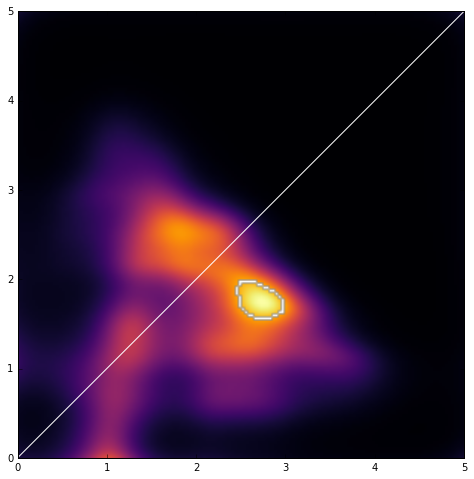

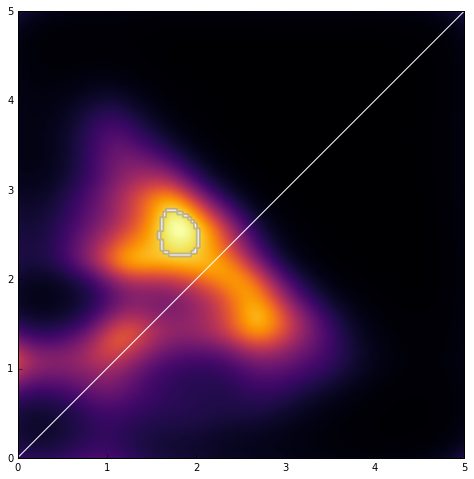

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

plt.figure(1, figsize=(8, 8))
plt.imshow(meanmap1,cmap=cm.inferno,origin='lower',extent=[0, 5, 0, 5])
plt.plot(np.arange(0,5,.01),np.arange(0,5,.01),color='w')
plt.show()
plt.figure(1, figsize=(8, 8))
plt.imshow(meanmap2,cmap=cm.inferno,origin='lower',extent=[0, 5, 0, 5])
plt.plot(np.arange(0,5,.01),np.arange(0,5,.01),color='w')
plt.show()